In [ ]:
#!pip install scikit-multilearn
#!pip install tqdm
#!pip install pymorphy2
#!pip install transformers
#!pip install transliterate

#!pip install torch==1.13.1
#!pip uninstall -y scipy gensim numpy tensorflow nltk
#!pip install numpy==1.26.4 scipy==1.12.0 gensim==4.3.2 tensorflow==2.16.1 nltk==3.8.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
import re
from skmultilearn.model_selection import IterativeStratification
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem.snowball import RussianStemmer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.multioutput import MultiOutputClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import torch.optim as optim
import gensim
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras.metrics import Precision, Recall
import transformers
import os
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoModelForSequenceClassification
from transformers import create_optimizer
from torch.optim import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, LSTM, Bidirectional
from tensorflow.keras.models import Model
from transliterate import translit
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df.head()

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29568 non-null  int64 
 1   text    29568 non-null  object
 2   labels  29568 non-null  object
dtypes: int64(1), object(2)
memory usage: 693.1+ KB


### Количество классов в train: 20

In [ ]:
num_labels = len(df['labels'].iloc[0].split())
num_labels

20

In [ ]:
df.groupby('labels')['text'].count().sort_values()

,text
labels,
0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0,1
1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1,1
1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0,1
1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1,1
1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0,1
...,...
0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0,477
1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0,510
0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0,727


In [ ]:
df[df['labels'] == '1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0']

,id,text,labels
73,73,Бизнес бранч на тему:\n«ПРОДВИЖЕНИЕ ЭКСПЕРТОВ ...,1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
92,92,🧠\nНейрографика:\nРог Изобилия\nот\nклуба Обра...,1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
108,108,РЕПЕРТУАР ТЕАТРА МИНИАТЮР ЛЕЙЛЫ ГОЛИЦИНОЙ(12+)...,1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
161,161,СОЗДАНИЕ НОВОГО БУДУЩЕГО\n4 ноября с 12:00 до ...,1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
168,168,"🎭\nStandUp PROверка материала в ресто-баре ""СИ...",1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
...,...,...,...
29482,29482,"STAND UP ""Проверка материала""\n30.03.2023 (ПО ...",1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
29503,29503,Если вы ищете место для единения с природой – ...,1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
29532,29532,21 февраля в 18:30 - 22:00\nТренинг-практикум ...,1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
29546,29546,"РЕПЕРТУАР ТЕАТРА-МУЗЕЯ ""БЛАГОДАТЬ""\nс 9 по 13 ...",1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0


### Кажется это данные с объявлениями развлекательных мероприятий: экскурсии, квн, дискотеки, концерты и тд. В тексте капслок, много лишних символов (/n), смайлики, цифры (время, дата - в разных форматах), есть слова на английском, возрастной ценз в скобках, много кавычек

### Посмотрим баланс классов/лейблов

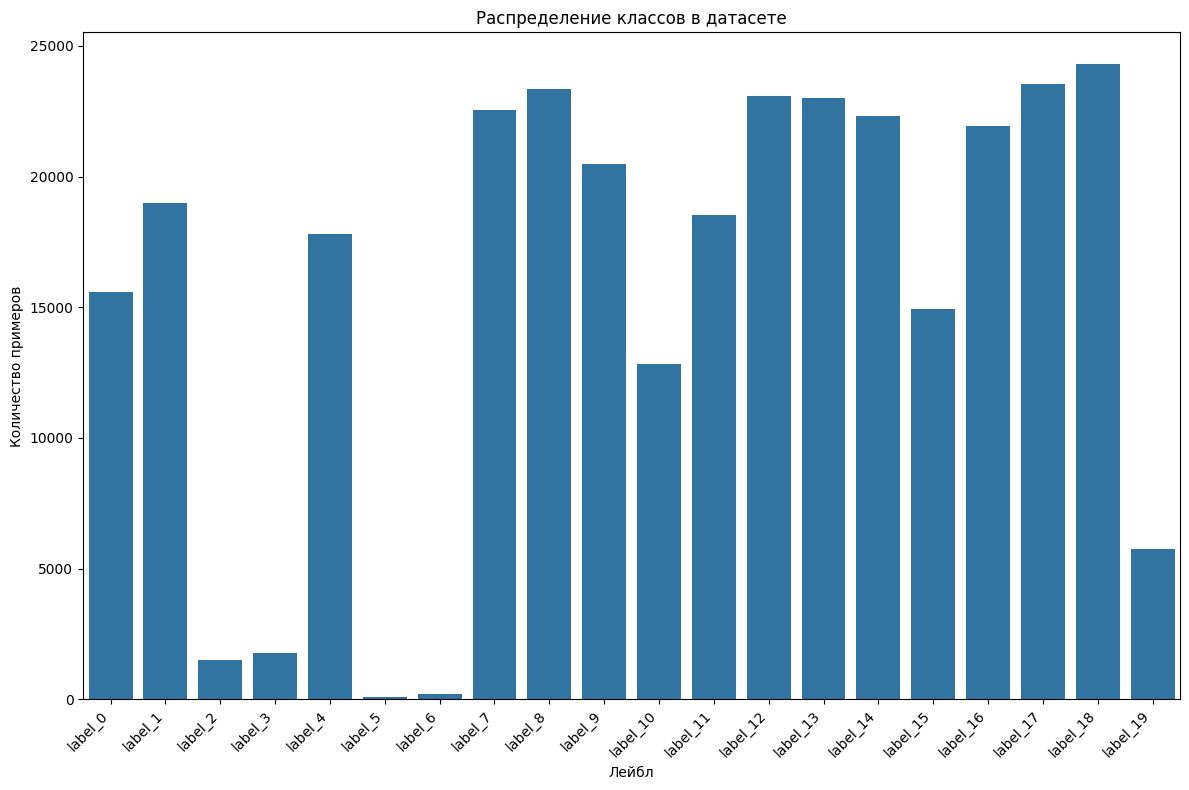

Количество примеров для каждого лейбла:
label_18    24300
label_17    23523
label_8     23344
label_12    23071
label_13    22997
label_7     22555
label_14    22296
label_16    21933
label_9     20497
label_1     18979
label_11    18510
label_4     17812
label_0     15582
label_15    14925
label_10    12811
label_19     5765
label_3      1776
label_2      1490
label_6       206
label_5        99
dtype: int64


In [ ]:
labels_expanded = df['labels'].str.split(expand=True)
labels_expanded.columns = [f'label_{i}' for i in range(num_labels)]
labels_expanded = labels_expanded.astype(int)
tag_counts = labels_expanded.sum()

plt.figure(figsize=(12, 8))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.title('Распределение классов в датасете')
plt.xlabel('Лейбл')
plt.ylabel('Количество примеров')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("Количество примеров для каждого лейбла:")
print(tag_counts.sort_values(ascending=False))

- label_5 и label_6 - самые редкие: удалить?
- label_2 и label_3 - менее редкие, но все же редкие: взвешивание классов?


In [ ]:
print("Типичные начала объявлений:", df['text'].str[:20].value_counts().head(5))
print("Частые спецсимволы:", Counter("".join(df['text']).replace(" ", "")))
print("Наличие смайлов:", df['text'].str.contains(r'[:;=]-?[\)\(DP]').sum())

Типичные начала объявлений: text
#афиша #афиша_москвы    403
Концерт «Вивальди. В    145
Концерт «Вселенная н     97
Бесплатная выставка      80
Иммерсивный спектакл     76
Name: count, dtype: int64
Частые спецсимволы: Counter({'о': 1217223, 'е': 1027696, 'а': 1018604, 'и': 940019, 'т': 796127, 'н': 735678, 'с': 705695, 'р': 690892, 'к': 531888, 'в': 509328, 'л': 450322, '\n': 425552, 'м': 379243, 'д': 349087, 'п': 334240, 'у': 304350, 'ы': 270458, 'я': 269403, 'г': 192275, 'ь': 187144, 'й': 180343, ',': 178575, 'з': 178320, 'б': 173182, '.': 164111, '0': 159957, 'ч': 131919, 'х': 103319, 'ж': 95079, '1': 94659, 'ш': 90391, ':': 84367, '2': 82639, '-': 82053, 't': 78698, 'ю': 71849, 'ц': 69036, 'e': 65881, 'С': 61652, 'К': 60260, 'a': 60226, 'А': 59425, 'В': 57800, 'ф': 57435, '/': 56382, 'П': 56317, 's': 52073, '#': 51743, 'М': 49935, 'О': 45103, 'Б': 44353, 'r': 43743, 'Н': 43707, 'Т': 42623, '3': 41090, 'Р': 41031, 'o': 40885, 'И': 39975, '«': 37412, '»': 37279, 'Д': 36094, '"': 346

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Препроцессинг



In [7]:
import inspect
if not hasattr(inspect, 'getargspec'):
    import collections
    def getargspec(func):
        sig = inspect.signature(func)
        args = []
        varargs = None
        varkw = None
        defaults = []
        for param in sig.parameters.values():
            if param.kind == param.VAR_POSITIONAL:
                varargs = param.name
            elif param.kind == param.VAR_KEYWORD:
                varkw = param.name
            else:
                args.append(param.name)
                if param.default is not param.empty:
                    defaults.append(param.default)
        return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(args, varargs, varkw, tuple(defaults) if defaults else None)
    inspect.getargspec = getargspec

tqdm.pandas()
morph = pymorphy2.MorphAnalyzer()
stemmer = RussianStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alinacesnokova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text, method='lemmatize'):
    # # приводим весь текст к нижнему регистру
    # text = text.lower()
    # # замена всего некиррилического на пробелы
    # text = re.sub(r'[^а-яё\s]', ' ', text)
    # # могли появиться повторные пробелы - удаляем их
    # text = re.sub(r'\s+', ' ', text).strip()
    # # токенизация (разбиение на слова)
    # tokens = text.split()

    text = re.sub(r'\b[a-z]+_[a-z0-9]+\b', '[SOCIAL]', text)  # Соцметки
    text = re.sub(r'\b[a-z]+[0-9]+\b', '[SOCIAL]', text)       # Хэштеги
    text = re.sub(r'\b[a-z]{1,3}\b', ' ', text)               # Удаляем короткие
    text = re.sub(r'\b[a-z]{4,}\b', '[ENG]', text)           # Остальные → [ENG]

    # Удаление email и URL
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    # Удаление дат (01.01.2023, 01/01/2023)
    text = re.sub(r'\b\d{1,2}[./]\d{1,2}[./]\d{2,4}\b', ' ', text)
    # Удаление времени (12:00, 12-00)
    text = re.sub(r'\b\d{1,2}[:-]\d{2}\b', ' ', text)
    # Удаление ценза (12+)
    text = re.sub(r'\(\d+\+\)', ' ', text)
    # Удаление смайлов и emoji
    text = re.sub(r'[^\w\s,;.!?а-яА-ЯёЁ-]', ' ', text)
    # Замена кавычек разных видов
    text = re.sub(r'[«»"“”„]', ' ', text)
    # Удаление одиночных букв и цифр
    text = re.sub(r'\b[а-яА-Яa-zA-Z]\b', ' ', text)
    text = re.sub(r'\b\d+\b', ' ', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации (кроме дефиса)
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()


    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    # удаление коротких слов и стоп слов
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

#### посмотрим на часто/редко встречающиеся слова/словосочетания

In [ ]:
cleaned_texts = [preprocess_text(text) for text in df['text']]

In [ ]:
all_words = []
for text in cleaned_texts:
    all_words.extend(text.split())

word_counts = Counter(all_words)

top_words = word_counts.most_common(30)
print("Топ-30 популярных слов:")
for word, count in top_words:
    print(f"{word}: {count}")

Топ-30 популярных слов:
билет: 24211
спектакль: 14162
скидка: 11948
концерт: 11795
промокод: 11281
театр: 11055
это: 10700
свой: 9224
который: 9161
год: 8806
ссылка: 8512
наш: 7271
весь: 6552
место: 6304
всё: 5872
новый: 5677
мероприятие: 5604
фестиваль: 5443
музыка: 5276
история: 5158
начало: 5151
хороший: 4801
москва: 4652
самый: 4603
выставка: 4601
время: 4581
музей: 4571
афиша: 4523
программа: 4504
шоу: 4404


In [ ]:
rare_words = [(word, cnt) for word, cnt in word_counts.items() if cnt <= 2]

rare_words_sorted = sorted(rare_words, key=lambda x: x[1])

print("\nТоп-30 редких слов (встречаются 1-2 раза):")
for word, count in rare_words_sorted[:30]:
    print(f"{word}: {count}")


Топ-30 редких слов (встречаются 1-2 раза):
мацуев: 1
сладковский: 1
dujarden: 1
этна: 1
хрипота: 1
hitmens: 1
дожди-пистолет: 1
метео: 1
5к2: 1
restobar: 1
селихов: 1
космосфильм: 1
чумаковый: 1
перемонтироваться: 1
тираны10: 1
спекткль: 1
23сентябрь: 1
17ноябрь: 1
извиняться: 1
будет-: 1
перформанс-инсталляция: 1
круг-: 1
человечно: 1
мультяшный: 1
запорожец: 1
обращёный: 1
конкурс-парад: 1
lildrughill: 1
showbiz: 1
factory3: 1


In [ ]:
all_bigrams = []
for text in cleaned_texts:
    tokens = text.split()
    all_bigrams.extend(list(bigrams(tokens)))

bigram_counts = Counter(all_bigrams).most_common(20)
print("\nТоп-20 сочетаний слов:")
for (w1, w2), count in bigram_counts:
    print(f"{w1} {w2}: {count}")


Топ-20 сочетаний слов:
билет скидка: 6537
билет ссылка: 5420
ссылка промокод: 4207
скидка промокод: 3219
скидка teatr_msk: 2846
наш канал: 2550
фестиваль концерт: 2448
концерт спектакль: 2445
подписаться наш: 2429
мероприятие выставка: 2421
выставка фестиваль: 2421
музей парка: 2420
афиша афиша_москва: 2418
афиша_москва мероприятие: 2418
парка подписаться: 2418
канал gomosevent: 2417
скидка teatrspb: 2344
вход свободный: 2008
репост приветствоваться: 1888
приветствоваться eventskmv: 1876


In [ ]:
eng_words = [word for word, cnt in word_counts.items() if re.search(r'[a-zA-Z]', word)]
print(f"Найдено {len(eng_words)} англоязычных слов. Примеры:", eng_words[:100])

Найдено 8562 англоязычных слов. Примеры: ['cafeotdyh', 'leontevaksenia', 'grand', 'piano', 'competition', '-pop', 'nella', 'musica', 'orchestra', 'dujarden', 'gomosevent', 'tik', 'teatrspb', 'bend', 'ave', 'maria', 'hitmens', 'elyaplugg', 'aurora', 'partyer', 'spbpromocodes', 'tilda', 'october', 'fest', 'rodizio', 'restobar', 'eventskmv', 'escobar', 'queen', 'metallica', 'muse', 'led', 'zeppelin', 'jony', 'music', 'awards', 'live', 'teatr_msk', 'bolshoi', 'white', 'afishaufa02', 'metod', 'mos', 'pro', 'stand-up', 'popravka', 'bar', 'fat', 'zodyakuz', 'prokontora', 'stage1', 'the', 'kursal', 'kary_noss', 'xviii', 'afishatg', 'love', 'jazz', 'and', 'stars', 'telegram', 'fly', 'moon', 'this', 'soft', 'quartet', 'afisha_rb', 'bittuev', 'niletto', 'bilet', 'project', 'atelier', 'lildrughill', 'showbiz', 'school', 'factory3', 'menedger_koncert', 'doc', 'crush', 'string', 'arman', 'shareen', 'cloud', 'nine', 'george', 'harrison', 'beatles', 'travelling', 'wilburys', 'jeff', 'lynne', 'roy', 'o

#### Слова, встречающиеся 1 раз странные, много на английском. Попробуем удалить (на tf-idf вышло хуже)

In [ ]:
all_words = [word for text in cleaned_texts for word in text.split()]
word_counts = Counter(all_words)

words_to_remove = {word for word, cnt in word_counts.items() if cnt == 1}

def remove_rare_words(text, rare_words):
    return ' '.join([word for word in text.split() if word not in rare_words])

# Применяем ко всем текстам
filtered_texts = [remove_rare_words(text, words_to_remove) for text in cleaned_texts]

In [ ]:
print("До очистки:", len(set(all_words)), "уникальных слов")
print("После удаления:", len(set(word for text in filtered_texts for word in text.split())), "уникальных слов")

До очистки: 56688 уникальных слов
После удаления: 34010 уникальных слов


In [12]:
def get_word_counts(texts):
    word_counts = Counter()
    for text in texts:
        # Применяем базовую токенизацию (без лемматизации, чтобы не искажать слова)
        tokens = re.findall(r'\b\w{3,}\b', text.lower())  # Берем слова от 3 символов
        word_counts.update(tokens)
    return word_counts

word_counts = get_word_counts(X_train)

def filter_rare_words(text, word_counts, min_count=2):
    tokens = re.findall(r'\b\w{3,}\b', text.lower())
    return ' '.join([word for word in tokens if word_counts.get(word, 0) >= min_count])

X_train_filtered = [filter_rare_words(text, word_counts) for text in X_train]

### Итоговый препроцессинг

In [9]:
def preprocess_text(text, method='lemmatize'):

    text = re.sub(r'\b[a-z]+_[a-z0-9]+\b', '[SOCIAL]', text)  # Соцметки
    text = re.sub(r'\b[a-z]+[0-9]+\b', '[SOCIAL]', text)       # Хэштеги
    text = re.sub(r'\b[a-z]{1,3}\b', ' ', text)               # Удаляем короткие
    text = re.sub(r'\b[a-z]{4,}\b', '[ENG]', text)           # Остальные → [ENG]

    # Удаление email и URL
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    # Удаление дат (01.01.2023, 01/01/2023)
    text = re.sub(r'\b\d{1,2}[./]\d{1,2}[./]\d{2,4}\b', ' ', text)
    # Удаление времени (12:00, 12-00)
    text = re.sub(r'\b\d{1,2}[:-]\d{2}\b', ' ', text)
    # Удаление ценза (12+)
    text = re.sub(r'\(\d+\+\)', ' ', text)
    # Удаление смайлов и emoji
    text = re.sub(r'[^\w\s,;.!?а-яА-ЯёЁ-]', ' ', text)
    # Замена кавычек разных видов
    text = re.sub(r'[«»"“”„]', ' ', text)
    # Удаление одиночных букв и цифр
    text = re.sub(r'\b[а-яА-Яa-zA-Z]\b', ' ', text)
    text = re.sub(r'\b\d+\b', ' ', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации (кроме дефиса)
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()


    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    # удаление коротких слов и стоп слов
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

### Разделим на train и val

#### **IterativeStratification** пытается распределить примеры так, чтобы соотношение каждой метки было примерно одинаковым в обучающей и валидационной выборках


In [11]:
y = np.array(df['labels'].apply(lambda x: list(map(int, x.split()))).tolist())
X = df['text'].values

k_fold = IterativeStratification(n_splits=5, order=1)
train_indexes, val_indexes = next(k_fold.split(X, y))

X_train, X_val = X[train_indexes], X[val_indexes]
y_train, y_val = y[train_indexes], y[val_indexes]

In [5]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер обучающей выборки: (23654,)
Размер валидационной выборки: (5914,)


#### Вспомогательные функции для построения модели: метрика, лоссы, свитч лосей, вормап, графики

In [13]:
class_counts = np.sum(y_train, axis=0)
class_weights = len(y_train) / (len(class_counts) * class_counts)

# Нормализация весов
class_weights = class_weights / np.sum(class_weights) * len(class_counts)

class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, name='f1_macro', threshold=0.5, **kwargs):
        super(F1Macro, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        # Инициализируем переменные для каждого класса
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        # Считаем TP, FP, FN для каждого класса
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

        # Обновляем состояния
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1)  # Макро-усреднение

    def reset_state(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))


class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, name='focal_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_pred * y_true + (1 - y_pred) * (1 - y_true)
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = tf.pow(1.0 - p_t, self.gamma)
        return tf.reduce_mean(alpha_factor * modulating_factor * bce, axis=-1)


class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, class_weights=None, name='weighted_binary_crossentropy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.class_weights = class_weights if class_weights is not None else []

    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        if len(self.class_weights) > 0:
            weights = tf.constant(self.class_weights, dtype=tf.float32)
            weighted_bce = bce * tf.reduce_sum(y_true * weights, axis=1)
            return tf.reduce_mean(weighted_bce)
        return tf.reduce_mean(bce)

    def get_config(self):
        config = super().get_config()
        config.update({'class_weights': self.class_weights})
        return config

class LossSwitcher(tf.keras.callbacks.Callback):
    def __init__(self, switch_epoch, new_loss):
        super().__init__()
        self.switch_epoch = switch_epoch
        self.new_loss = new_loss
        self.original_loss = None

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.switch_epoch:
            self.original_loss = self.model.loss
            self.model.loss = self.new_loss
            print(f"\nSwitched loss from {self.original_loss.__class__.__name__} to {self.new_loss.__class__.__name__}")


def warmup_exp_decay(epoch):
    warmup_epochs = 5
    init_lr = 1e-5
    peak_lr = 1e-3
    decay_rate = 0.9

    if epoch < warmup_epochs:
        return init_lr + (peak_lr - init_lr) * (epoch / warmup_epochs)
    else:
        return peak_lr * (decay_rate ** (epoch - warmup_epochs))

def plot_training_history(history, switch_epoch=None):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    if switch_epoch:
        plt.axvline(x=switch_epoch, color='r', linestyle='--', label='Loss Switch')
    plt.title('Loss Dynamics')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_macro'], label='Train F1')
    plt.plot(history.history['val_f1_macro'], label='Val F1')
    plt.title('F1-Macro Score')
    plt.legend()

    plt.show()

## 1. tf-idf + любая нейронная сеть (DNN)

In [ ]:
preprocessor = Pipeline([
    ('text_clean', FunctionTransformer(lambda texts: [preprocess_text(t) for t in texts], validate=False)),
    ('vectorizer', TfidfVectorizer(max_features=1000))
])

X_train_vec = preprocessor.fit_transform(X_train) #X_train_filtered
X_val_vec = preprocessor.transform(X_val)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


730/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_macro: 0.4466 - loss: 0.3830
Epoch 1: val_f1_macro improved from -inf to 0.59235, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_macro: 0.4477 - loss: 0.3830 - val_f1_macro: 0.5923 - val_loss: 0.4945 - learning_rate: 1.0000e-05
Epoch 2/20
727/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_macro: 0.6104 - loss: 0.2804
Epoch 2: val_f1_macro improved from 0.59235 to 0.71833, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_macro: 0.6112 - loss: 0.2797 - val_f1_macro: 0.7183 - val_loss: 0.2516 - learning_rate: 2.0800e-04
Epoch 3/20
732/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_macro: 0.7246 - loss: 0.1782
Epoch 3: val_f1_macro improved from 0.71833 to 0.77819, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_macro: 0.7248 - loss: 0.1782 - val_f1_macro: 0.7782 - val_loss: 0.2067 - learning_rate: 4.0600e-04
Epoch 4/20
728/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

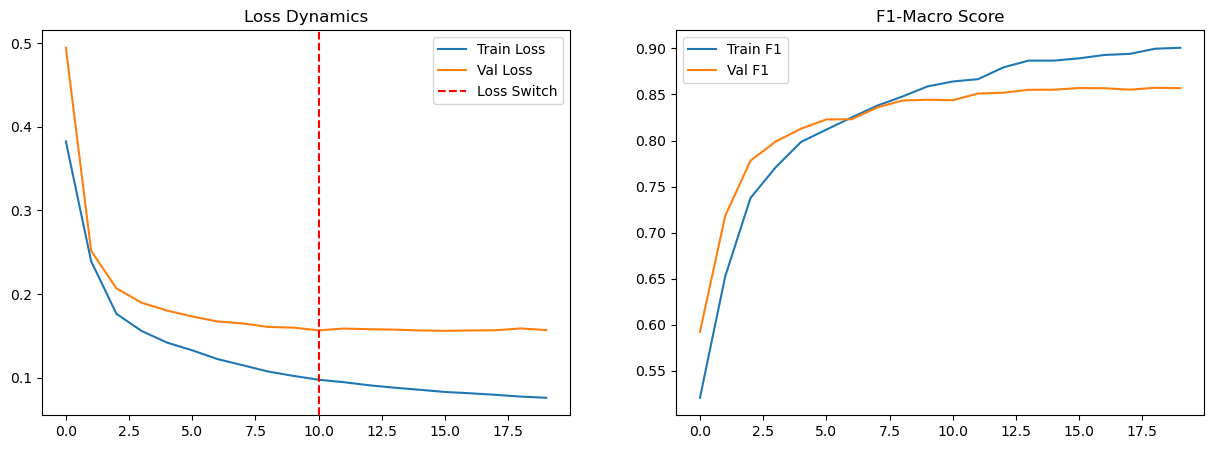

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
Best model F1-macro: 0.8573


In [ ]:
X_train_dense = X_train_vec.toarray()
X_val_dense = X_val_vec.toarray()

num_features = X_train_dense.shape[1]
num_classes = y_train.shape[1]

# Создание модели
model = Sequential([
    Dense(512, activation='relu', input_shape=(num_features,)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=WeightedBinaryCrossentropy(class_weights),
    metrics=[F1Macro()]
)



callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=3, mode='max', restore_best_weights=True), # Ранняя остановка
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    LearningRateScheduler(warmup_exp_decay),
    CSVLogger('training_log.csv'),
    LossSwitcher(switch_epoch=10, new_loss=FocalLoss())
]



# 5. Обучение с добавлением sample_weight для взвешивания классов
sample_weights = np.sum(y_train * class_weights, axis=1)

history = model.fit(
    X_train_dense,
    y_train,
    sample_weight=sample_weights,
    validation_data=(X_val_dense, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Визуализация
plot_training_history(history, switch_epoch=10)

# Загрузка лучшей модели
best_model = tf.keras.models.load_model('best_model.keras',
                                      custom_objects={
                                          'F1Macro': F1Macro,
                                          'FocalLoss': FocalLoss,
                                          'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy
                                      })

y_pred = best_model.predict(X_val_dense) > 0.5
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")

## 2. w2v + любая нейронная сеть (DNN)

In [ ]:
preprocessed_texts_train = [preprocess_text(text) for text in X_train]
preprocessed_texts_val = [preprocess_text(text) for text in X_val]

tokenized_texts = [text.split() for text in preprocessed_texts_train]

# Обучение W2V модели
w2v_model = Word2Vec(
    sentences = tokenized_texts,
    vector_size = 200,    # Размер эмбеддингов
    window = 3,           # Размер окна контекста
    min_count = 5,        # Минимальная частота слова
    workers = 4,
    epochs = 10
)

def text_to_avg_w2v(text, model, vector_size=200):
    words = text.split()
    vectors = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Преобразование данных
X_train_w2v = np.array([text_to_avg_w2v(text, w2v_model) for text in X_train])
X_val_w2v = np.array([text_to_avg_w2v(text, w2v_model) for text in X_val])

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


721/740 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_macro: 0.4558 - loss: 0.5161
Epoch 1: val_f1_macro improved from -inf to 0.47303, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_macro: 0.4561 - loss: 0.5158 - val_f1_macro: 0.4730 - val_loss: 0.5711 - learning_rate: 1.0000e-05
Epoch 2/30
719/740 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_macro: 0.5513 - loss: 0.4085
Epoch 2: val_f1_macro improved from 0.47303 to 0.67841, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_macro: 0.5524 - loss: 0.4071 - val_f1_macro: 0.6784 - val_loss: 0.3335 - learning_rate: 2.0800e-04
Epoch 3/30
712/740 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_macro: 0.6645 - loss: 0.2632
Epoch 3: val_f1_macro improved from 0.67841 to 0.71343, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_macro: 0.6650 - loss: 0.2625 - val_f1_macro: 0.7134 - val_loss: 0.2675 - learning_rate: 4.0600e-04
Epoch 4/30
728/740 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

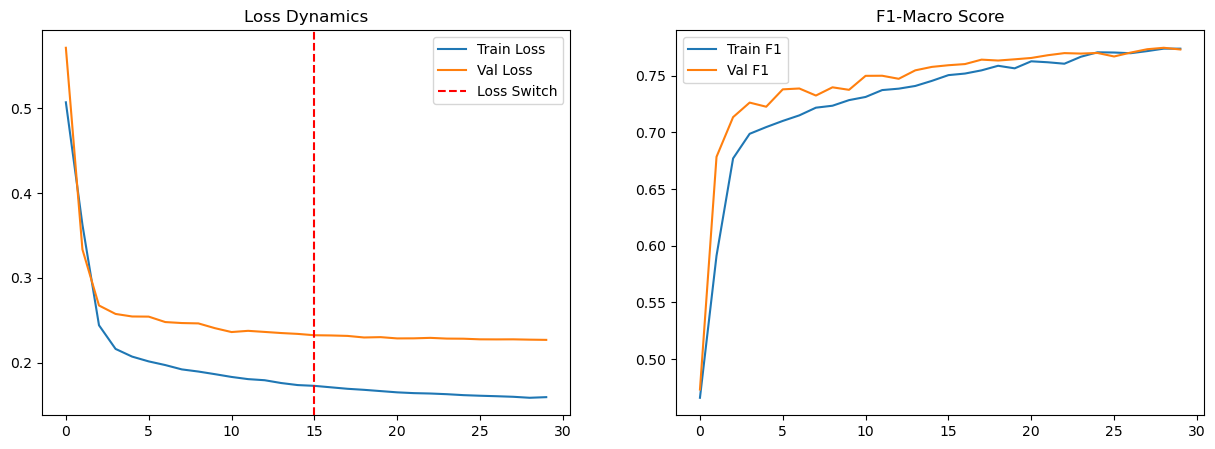

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
Best model F1-macro: 0.7747


In [ ]:
num_features = X_train_w2v.shape[1]

model = Sequential([
    Dense(512, activation='relu', input_shape=(num_features,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=WeightedBinaryCrossentropy(class_weights),
    metrics=[F1Macro()]
)

callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=3, mode='max', restore_best_weights=True),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    LearningRateScheduler(warmup_exp_decay),
    CSVLogger('training_log.csv'),
    LossSwitcher(switch_epoch=15, new_loss=FocalLoss())
]

sample_weights = np.sum(y_train * class_weights, axis=1) #взвешивание классов

history = model.fit(
    X_train_w2v,
    y_train,
    sample_weight=sample_weights,
    validation_data=(X_val_w2v, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

plot_training_history(history, switch_epoch=15)

best_model = tf.keras.models.load_model('best_model.keras',
                                      custom_objects={
                                          'F1Macro': F1Macro,
                                          'FocalLoss': FocalLoss,
                                          'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy
                                      })

y_pred = best_model.predict(X_val_w2v) > 0.5
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")

## Встроенный эмбеддинг в нейросетевое решение на свёрточных сетях

## 0.85 на кагле

In [29]:
preprocessor = Pipeline([
    ('text_clean', FunctionTransformer(lambda texts: [preprocess_text(t) for t in texts], validate=False))])

X_train_cnn = preprocessor.fit_transform(X_train)
X_val_cnn = preprocessor.transform(X_val)

In [31]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_cnn)

X_train_seq = tokenizer.texts_to_sequences(X_train_cnn)
X_val_seq = tokenizer.texts_to_sequences(X_val_cnn)

lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))
print('max_len:', max_len)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1

max_len: 115


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


739/740 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - f1_macro: 0.5084 - loss: 0.4154
Epoch 1: val_f1_macro improved from -inf to 0.57133, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - f1_macro: 0.5085 - loss: 0.4153 - val_f1_macro: 0.5713 - val_loss: 0.4669 - learning_rate: 1.0000e-05
Epoch 2/20
739/740 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - f1_macro: 0.6061 - loss: 0.3113
Epoch 2: val_f1_macro improved from 0.57133 to 0.68663, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - f1_macro: 0.6062 - loss: 0.3113 - val_f1_macro: 0.6866 - val_loss: 0.2708 - learning_rate: 2.0800e-04
Epoch 3/20
739/740 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - f1_macro: 0.6900 - loss: 0.2332
Epoch 3: val_f1_macro improved from 0.68663 to 0.73594, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 45s 61ms/step - f1_macro: 0.6900 - loss: 0.2331 - val_f1_macro: 0.7359 - val_loss: 0.2289 - learning_rate: 4.0600e-04
Epoch 4/20
739/740 ━━━━━━━━━━━━━━━━━━━━ 0s 69

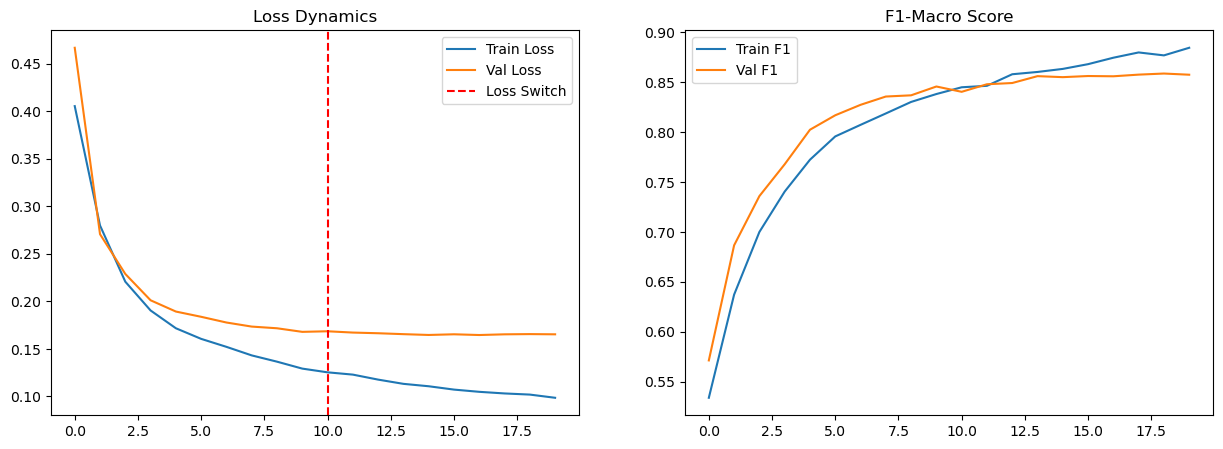

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Best model F1-macro: 0.8587


In [33]:
num_classes = 20

def CNN(vocab_size, embed_dim, input_len, num_classes):
    inp = Input(shape=(input_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_len)(inp)

    convs = []
    for size in [3, 4, 5]:
        c = Conv1D(128, kernel_size=size, activation='relu')(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model = CNN(vocab_size, embed_dim=256, input_len=max_len, num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=WeightedBinaryCrossentropy(class_weights),
    metrics=[F1Macro()]
)

callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=3, mode='max', restore_best_weights=True),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    LearningRateScheduler(warmup_exp_decay),
    CSVLogger('training_log.csv'),
    LossSwitcher(switch_epoch=10, new_loss=FocalLoss())
]


sample_weights = np.sum(y_train * class_weights, axis=1)
history = model.fit(
    X_train_pad,
    y_train,
    sample_weight=sample_weights,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


plot_training_history(history, switch_epoch=10)

best_model = tf.keras.models.load_model('best_model.keras',
                                      custom_objects={
                                          'F1Macro': F1Macro,
                                          'FocalLoss': FocalLoss,
                                          'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy
                                      })

y_pred = best_model.predict(X_val_pad) > 0.5
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")

#### а если изменить порог бинаризации?

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Macro-average ROC-AUC: 0.9464


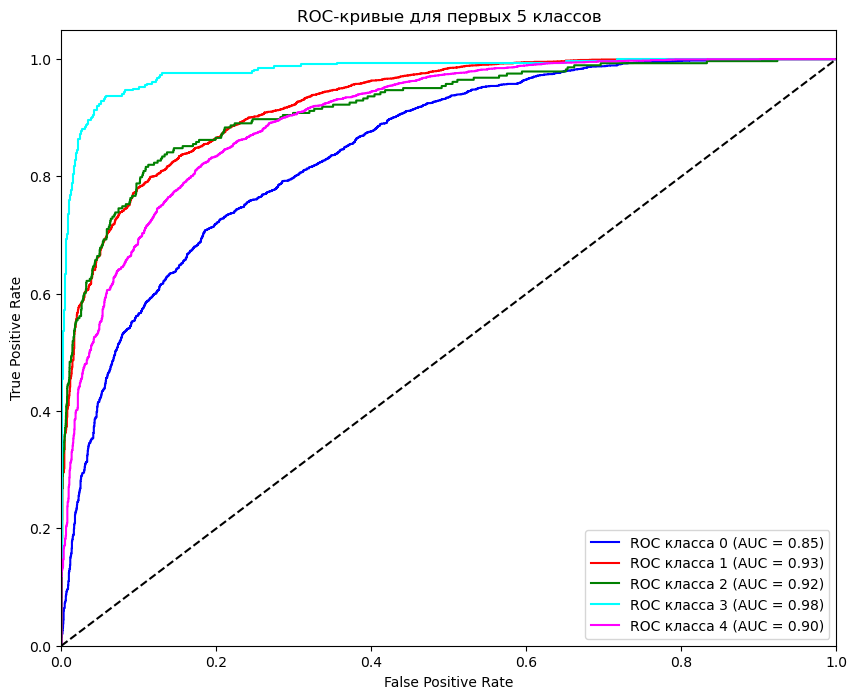


AUC для каждого класса:
Класс 0: 0.8455
Класс 1: 0.9265
Класс 2: 0.9182
Класс 3: 0.9805
Класс 4: 0.9028
Класс 5: 0.9673
Класс 6: 0.9447
Класс 7: 0.8951
Класс 8: 0.9891
Класс 9: 0.9591
Класс 10: 0.9714
Класс 11: 0.9609
Класс 12: 0.9144
Класс 13: 0.9477
Класс 14: 0.9224
Класс 15: 0.9525
Класс 16: 0.9721
Класс 17: 0.9807
Класс 18: 0.9897
Класс 19: 0.9880


In [51]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

#Получаем предсказания вероятностей
y_probs = best_model.predict(X_val_pad)

#Вычисляем ROC-AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Средний ROC-AUC (macro)
roc_auc_macro = roc_auc_score(y_val, y_probs, average='macro')
print(f"Macro-average ROC-AUC: {roc_auc_macro:.4f}")

#Визуализация ROC-кривых для первых 5 классов 
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'cyan', 'magenta']

for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC класса {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для первых 5 классов')
plt.legend(loc="lower right")
plt.show()

# Полная таблица AUC для всех классов
print("\nAUC для каждого класса:")
for i in range(num_classes):
    print(f"Класс {i}: {roc_auc[i]:.4f}")

In [41]:
def find_optimal_threshold(model, X_val, y_val, num_classes=20, steps=100):
    #Получаем предсказанные вероятности
    y_probs = model.predict(X_val)
    
    #Диапазон порогов от 0.1 до 0.9 с шагом 0.01
    thresholds = np.linspace(0.1, 0.9, steps)
    best_thresholds = np.zeros(num_classes)
    best_scores = np.zeros(num_classes)
    
    #Поиск для каждого класса отдельно
    for class_idx in range(num_classes):
        max_f1 = 0
        best_thresh = 0.5  #дефолтный порог
        
        for thresh in thresholds:
            #Бинаризация с текущим порогом
            y_pred = (y_probs[:, class_idx] > thresh).astype(int)
            #Вычисляем F1 для текущего класса
            f1 = f1_score(y_val[:, class_idx], y_pred, zero_division=0)
            
            if f1 > max_f1:
                max_f1 = f1
                best_thresh = thresh
        
        best_thresholds[class_idx] = best_thresh
        best_scores[class_idx] = max_f1
    
    #Также найдем общий оптимальный порог для macro F1
    overall_best_thresh = 0.5
    overall_max_f1 = 0
    
    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        f1 = f1_score(y_val, y_pred, average='macro')
        if f1 > overall_max_f1:
            overall_max_f1 = f1
            overall_best_thresh = thresh
    
    return {
        'class_thresholds': best_thresholds,
        'class_scores': best_scores,
        'overall_threshold': overall_best_thresh,
        'overall_score': overall_max_f1
    }

In [43]:
# Поиск оптимальных порогов
threshold_results = find_optimal_threshold(best_model, X_val_pad, y_val)

# Вывод результатов
print("Лучшие пороги для каждого класса:")
for class_idx in range(num_classes):
    print(f"Класс {class_idx}: порог = {threshold_results['class_thresholds'][class_idx]:.3f}, "
          f"F1 = {threshold_results['class_scores'][class_idx]:.3f}")

print(f"\nОбщий оптимальный порог: {threshold_results['overall_threshold']:.3f}")
print(f"Macro F1 с общим порогом: {threshold_results['overall_score']:.3f}")

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Лучшие пороги для каждого класса:
Класс 0: порог = 0.407, F1 = 0.788
Класс 1: порог = 0.383, F1 = 0.886
Класс 2: порог = 0.480, F1 = 0.575
Класс 3: порог = 0.585, F1 = 0.785
Класс 4: порог = 0.447, F1 = 0.862
Класс 5: порог = 0.383, F1 = 0.350
Класс 6: порог = 0.738, F1 = 0.952
Класс 7: порог = 0.464, F1 = 0.901
Класс 8: порог = 0.407, F1 = 0.978
Класс 9: порог = 0.561, F1 = 0.939
Класс 10: порог = 0.423, F1 = 0.902
Класс 11: порог = 0.439, F1 = 0.923
Класс 12: порог = 0.464, F1 = 0.930
Класс 13: порог = 0.488, F1 = 0.938
Класс 14: порог = 0.585, F1 = 0.925
Класс 15: порог = 0.407, F1 = 0.883
Класс 16: порог = 0.520, F1 = 0.949
Класс 17: порог = 0.456, F1 = 0.968
Класс 18: порог = 0.375, F1 = 0.979
Класс 19: порог = 0.593, F1 = 0.894

Общий оптимальный порог: 0.464
Macro F1 с общим порогом: 0.862


In [45]:
y_pred_custom = np.zeros_like(y_val)
for class_idx in range(num_classes):
    y_pred_custom[:, class_idx] = (best_model.predict(X_val_pad)[:, class_idx] > 
                                  threshold_results['class_thresholds'][class_idx]).astype(int)
f1_custom = f1_score(y_val, y_pred_custom, average='macro')
print(f"F1 с индивидуальными порогами: {f1_custom:.4f}")

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
F1 с индивидуальными порогами: 0.8652


In [49]:
y_pred = best_model.predict(X_val_pad) > 0.464
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Best model F1-macro: 0.8619


## Встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [ ]:
preprocessor = Pipeline([
    ('text_clean', FunctionTransformer(lambda texts: [preprocess_text(t) for t in texts], validate=False))])

X_train_rnn = preprocessor.fit_transform(X_train)
X_val_rnn = preprocessor.transform(X_val)

In [ ]:
tokenizer = Tokenizer(
    num_words=15000,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=False,
    char_level=False
)
tokenizer.fit_on_texts(X_train_rnn)

X_train_seq = tokenizer.texts_to_sequences(X_train_rnn)
X_val_seq = tokenizer.texts_to_sequences(X_val_rnn)

lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))
print('max_len:', max_len)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='pre')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='pre')

vocab_size = len(tokenizer.word_index) + 1

max_len: 114


Epoch 1/20
739/740 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - f1_macro: 0.5336 - loss: 0.3791
Epoch 1: val_f1_macro improved from -inf to 0.57313, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 67s 89ms/step - f1_macro: 0.5337 - loss: 0.3791 - val_f1_macro: 0.5731 - val_loss: 0.4167 - learning_rate: 1.0000e-05
Epoch 2/20
739/740 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - f1_macro: 0.6665 - loss: 0.2433
Epoch 2: val_f1_macro improved from 0.57313 to 0.70645, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 69s 93ms/step - f1_macro: 0.6666 - loss: 0.2433 - val_f1_macro: 0.7065 - val_loss: 0.2388 - learning_rate: 2.0800e-04
Epoch 3/20
739/740 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - f1_macro: 0.7111 - loss: 0.1923
Epoch 3: val_f1_macro improved from 0.70645 to 0.74459, saving model to best_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 67s 91ms/step - f1_macro: 0.7111 - loss: 0.1923 - val_f1_macro: 0.7446 - val_loss: 0.2226 - learning_rate: 4.0600e-04
Epoch 4/20
739/740 ━━━━━━━━━━━━━━━

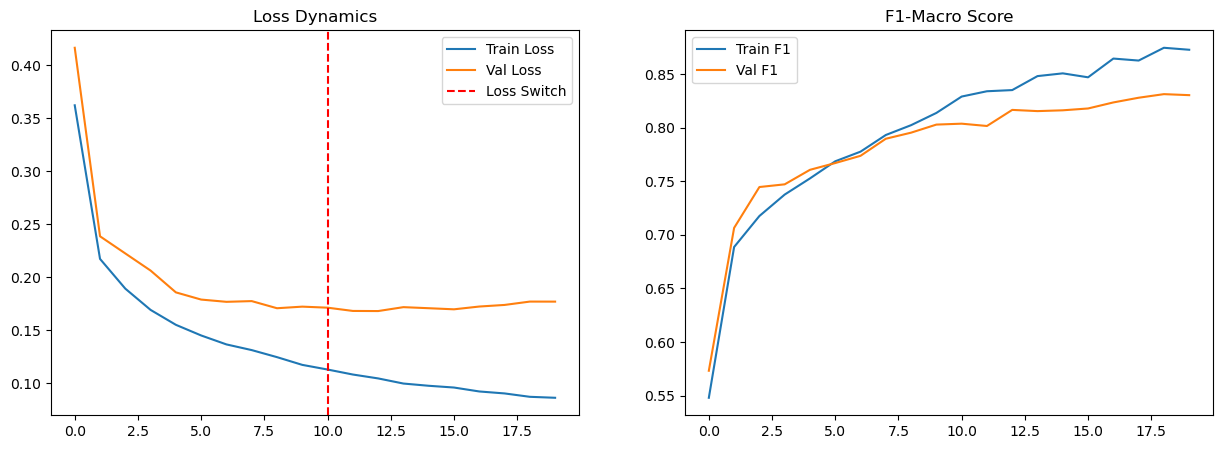

185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Best model F1-macro: 0.8313


In [ ]:
num_classes = 20

def RNN(vocab_size, embed_dim, input_len, num_classes):
    inp = Input(shape=(input_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inp)

    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model = RNN(vocab_size, embed_dim=100, input_len=max_len, num_classes=num_classes) #попробовать 256/512

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=WeightedBinaryCrossentropy(class_weights),
    metrics=[F1Macro()]
)

callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=3, mode='max', restore_best_weights=True),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    LearningRateScheduler(warmup_exp_decay),
    CSVLogger('training_log.csv'),
    LossSwitcher(switch_epoch=10, new_loss=FocalLoss())
]


sample_weights = np.sum(y_train * class_weights, axis=1)
history = model.fit(
    X_train_pad,
    y_train,
    sample_weight=sample_weights,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


plot_training_history(history, switch_epoch=10)

best_model = tf.keras.models.load_model('best_model.keras',
                                      custom_objects={
                                          'F1Macro': F1Macro,
                                          'FocalLoss': FocalLoss,
                                          'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy
                                      })

y_pred = best_model.predict(X_val_pad) > 0.5
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")

## bert-like

#### препроцессинг для bert

In [6]:
def bert_preprocess(text, whitelist=['shop', 'club', 'bar']):
    # 1. Базовая очистка
    text = re.sub(r'http\S+', '[URL]', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # 2. Обработка специальных шаблонов
    text = re.sub(r'\b\d{1,2}[:.]\d{2}\b', '[TIME]', text)
    text = re.sub(r'\b\d+[+]\b', '[AGE]', text)  # 18+

    # 3. Обработка соцметок
    text = re.sub(r'(@\w+)', r' \1 ', text)
    text = re.sub(r'(#\w+)', r' \1 ', text)

    # 4. Английские слова (сохраняем whitelist)
    english_whitelist = set(whitelist)
    text = re.sub(r'\b([a-z]+)\b',
                 lambda m: m.group(1) if m.group(1) in english_whitelist else
                          translit(m.group(1), 'ru', reversed=True),
                 text, flags=re.I)

    return text

In [7]:
preprocessor = Pipeline([
    ('text_clean', FunctionTransformer(lambda texts: [bert_preprocess(t) for t in texts], validate=False)),
])

X_train_bert = preprocessor.fit_transform(X_train)
X_val_bert = preprocessor.transform(X_val)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ba11017f-2aa0-4251-94ac-be7df28135d7)')' thrown while requesting HEAD https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/tokenizer_config.json
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jupyter/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 1478/1478 [04:36<00:00,  5.35it/s]


Epoch 1, Loss: 0.2654, Val F1: 0.7471


Epoch 2/10: 100%|██████████| 1478/1478 [04:37<00:00,  5.32it/s]


Epoch 2, Loss: 0.1857, Val F1: 0.7877


Epoch 3/10: 100%|██████████| 1478/1478 [04:38<00:00,  5.31it/s]


Epoch 3, Loss: 0.1478, Val F1: 0.8111


Epoch 4/10: 100%|██████████| 1478/1478 [04:37<00:00,  5.32it/s]


Epoch 4, Loss: 0.1188, Val F1: 0.8153


Epoch 5/10: 100%|██████████| 1478/1478 [04:37<00:00,  5.32it/s]


Epoch 5, Loss: 0.0990, Val F1: 0.8150

 Switched to FocalLoss at epoch 5


Epoch 6/10: 100%|██████████| 1478/1478 [04:38<00:00,  5.32it/s]


Epoch 6, Loss: 0.0045, Val F1: 0.8445


Epoch 7/10: 100%|██████████| 1478/1478 [04:37<00:00,  5.32it/s]


Epoch 7, Loss: 0.0029, Val F1: 0.8503


Epoch 8/10: 100%|██████████| 1478/1478 [04:38<00:00,  5.31it/s]


Epoch 8, Loss: 0.0028, Val F1: 0.8477


Epoch 9/10: 100%|██████████| 1478/1478 [04:38<00:00,  5.31it/s]


Epoch 9, Loss: 0.0034, Val F1: 0.8379


Epoch 10/10: 100%|██████████| 1478/1478 [04:38<00:00,  5.31it/s]


Epoch 10, Loss: 0.0035, Val F1: 0.8375

 Final F1-score: 0.8503


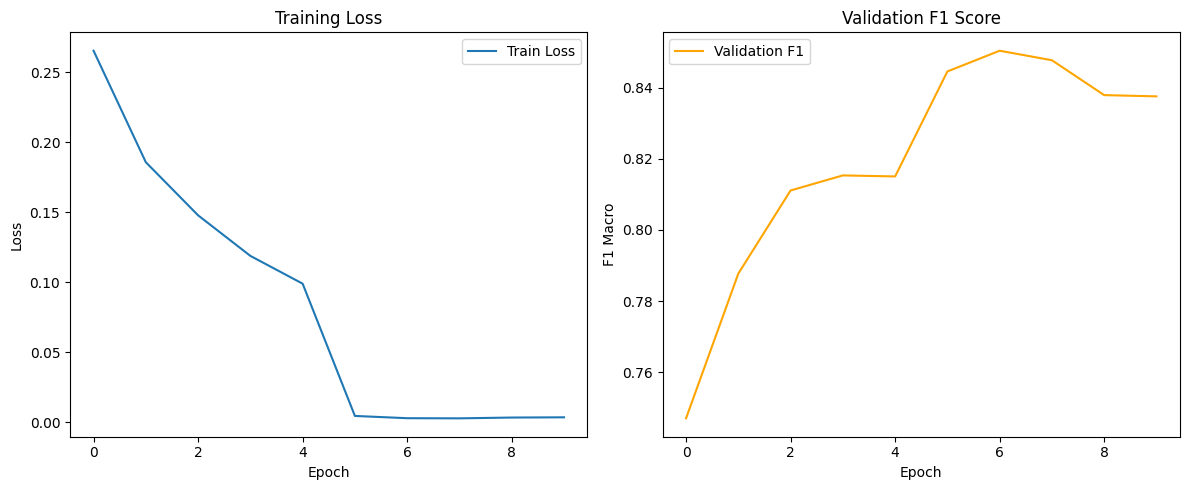

In [20]:
num_classes = 20
model_name = 'DeepPavlov/rubert-base-cased'
max_length = 114
batch_size = 24
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Модель
tokenizer = BertTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    problem_type="multi_label_classification"
).to(device)

#Датасет
class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.FloatTensor(self.labels[idx])
        }

#Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return loss.mean()

#Свитч лося
class LossSwitcher:
    def __init__(self, initial_loss, switch_epoch, new_loss):
        self.initial_loss = initial_loss
        self.new_loss = new_loss
        self.switch_epoch = switch_epoch
        self.current_loss = initial_loss

    def switch(self, epoch):
        if epoch == self.switch_epoch:
            self.current_loss = self.new_loss
            print(f"\n Switched to {type(self.new_loss).__name__} at epoch {epoch}")
        return self.current_loss

#f1
def calculate_f1(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(outputs.logits) > 0.5
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return f1_score(true_labels, predictions, average='macro')

#Загрузка данных
train_dataset = MultilabelDataset(X_train_bert, y_train, tokenizer)
val_dataset = MultilabelDataset(X_val_bert, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

#Оптимизатор и лоссы 
optimizer = AdamW(model.parameters(), lr=0.0001)
bce_loss = nn.BCEWithLogitsLoss()
focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
loss_switcher = LossSwitcher(initial_loss=bce_loss, switch_epoch=5, new_loss=focal_loss)

#Обучение
train_loss_history = []
val_f1_history = []
best_f1 = 0
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    criterion = loss_switcher.switch(epoch)

    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    val_f1 = calculate_f1(model, val_loader)

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}')

    train_loss_history.append(avg_loss)
    val_f1_history.append(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pt')

#Лучшая модель
model.load_state_dict(torch.load('best_model.pt'))
final_f1 = calculate_f1(model, val_loader)
print(f'\n Final F1-score: {final_f1:.4f}')

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_history, label='Validation F1', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Macro')
plt.title('Validation F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
# %pip install torch==2.0.1+cu118 transformers==4.34.0 -f https://download.pytorch.org/whl/torch_stable.html

## Генерация примеров

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Загружаем модель и токенайзер
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.eval()


#Функция для выбора топ-K частых комбинаций меток
def sample_multilabel_combinations(y_train, top_k=20):
    combo_strings = [''.join(map(str, row)) for row in y_train]
    combo_counts = Counter(combo_strings)
    top_combos = combo_counts.most_common(top_k)
    top_combos = [(np.array(list(map(int, c))), count) for c, count in top_combos]
    return top_combos

#Генерация текста по заданным меткам 
def generate_texts_for_labels(combo_vec, num_samples, max_length=120):
    active_labels = [str(i+1) for i, v in enumerate(combo_vec) if v == 1]
    prompt_text = f"Темы: {', '.join(active_labels)}. Текст:"

    inputs = tokenizer.encode(prompt_text, return_tensors='pt').to(device)
    
    outputs = model.generate(
        inputs,
        max_length=max_length + len(inputs[0]),
        do_sample=True,
        top_p=0.9,
        top_k=50,
        num_return_sequences=num_samples,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    
    texts = []
    for output in outputs:
        decoded = tokenizer.decode(output, skip_special_tokens=True)
        text = decoded[len(prompt_text):].strip()
        texts.append(text)
    return texts

#Генерируем данные пропорционально частоте меток
def generate_synthetic_multilabel_data(y_train, num_samples=1000, top_k=20):
    top_combos = sample_multilabel_combinations(y_train, top_k)
    total_count = sum([count for _, count in top_combos])
    
    X_synthetic = []
    y_synthetic = []
    
    for combo_vec, count in top_combos:
        sample_count = int((count / total_count) * num_samples)
        if sample_count == 0:
            continue
        gen_texts = generate_texts_for_labels(combo_vec, sample_count)
        X_synthetic.extend(gen_texts)
        y_synthetic.extend([combo_vec] * sample_count)
        
    return np.array(X_synthetic), np.array(y_synthetic)


X_synthetic, y_synthetic = generate_synthetic_multilabel_data(y_train, num_samples=1000)

# Объединяем с исходными данными
X_train_full = np.concatenate([X_train, X_synthetic])
y_train_full = np.concatenate([y_train, y_synthetic])


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


model.safetensors:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [76]:
X_synthetic[:10] #нагенирировались странные примеры

array(['2.1. «Неожиданная развязка» (лат.). Автор и переводчики: Э. В. Сафонова (Э. В. Сафонова), Г. А. Демидова (Г. А. Демидова), А. Г. Кабанова (Г. А. Кабанова). Сценарий: Сценарий «Ляля» был снят по мотивам произведения Я. К. Маршака «Соловей и его спутники», который в 1929 году',
       'Н. П. Павлов, И. В. Чухрай, С. В. Черкасская.\n\nВ тексте использованы работы ученых-историков, искусствоведов, представителей ряда учебных заведений и институтов, занимающихся исследованием вопросов изучения древней истории Руси.',
       '1. А. П. Чехов в воспоминаниях современников: 2-я часть. Рассказы / П. П. Чехов. - М.: ТГГУ, 2004. - С. 23-28. - ISBN 5-899-21388-0. - (Рецензия на книгу)\n\n\n27929578\telena-cherni\t2005-09-15 06:50:00\tЛетом я ездила в Грецию',
       '«Я люблю тебя. Я люблю тебя» – с таким напутствием к каждому ученику я буду читать эту книгу. На этом месте я читаю отрывок из книги «Художественные поиски истины». «Я люблю тебя» в двух строчках, а я на середине, а рядом – «Я 

In [79]:
preprocessor = Pipeline([
    ('text_clean', FunctionTransformer(lambda texts: [preprocess_text(t) for t in texts], validate=False))])

X_train_cnn = preprocessor.fit_transform(X_train_full)
X_val_cnn = preprocessor.transform(X_val)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_cnn)

X_train_seq = tokenizer.texts_to_sequences(X_train_cnn)
X_val_seq = tokenizer.texts_to_sequences(X_val_cnn)

lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))
print('max_len:', max_len)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1

max_len: 112


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


771/771 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1_macro: 0.4340 - loss: 0.4270
Epoch 1: val_f1_macro improved from -inf to 0.54974, saving model to best_model.keras
771/771 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - f1_macro: 0.4341 - loss: 0.4270 - val_f1_macro: 0.5497 - val_loss: 0.4876 - learning_rate: 1.0000e-05
Epoch 2/20
770/771 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - f1_macro: 0.5904 - loss: 0.3159
Epoch 2: val_f1_macro improved from 0.54974 to 0.68669, saving model to best_model.keras
771/771 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - f1_macro: 0.5905 - loss: 0.3158 - val_f1_macro: 0.6867 - val_loss: 0.2712 - learning_rate: 2.0800e-04
Epoch 3/20
770/771 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - f1_macro: 0.6813 - loss: 0.2284
Epoch 3: val_f1_macro improved from 0.68669 to 0.75193, saving model to best_model.keras
771/771 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - f1_macro: 0.6814 - loss: 0.2284 - val_f1_macro: 0.7519 - val_loss: 0.2239 - learning_rate: 4.0600e-04
Epoch 4/20
770/771 ━━━━━━━━━━━━━━━━━━━━ 0s 54

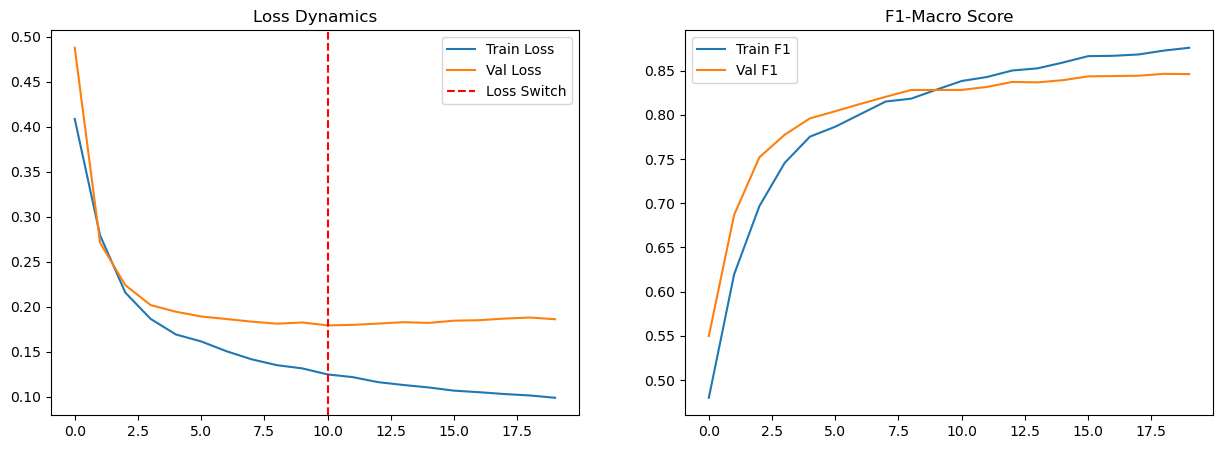

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Best model F1-macro: 0.8463


In [81]:
num_classes = 20

def CNN(vocab_size, embed_dim, input_len, num_classes):
    inp = Input(shape=(input_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inp)

    convs = []
    for size in [3, 4, 5]:
        c = Conv1D(128, kernel_size=size, activation='relu')(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model = CNN(vocab_size, embed_dim=256, input_len=max_len, num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=WeightedBinaryCrossentropy(class_weights),
    metrics=[F1Macro()]
)

callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=3, mode='max', restore_best_weights=True),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    LearningRateScheduler(warmup_exp_decay),
    CSVLogger('training_log.csv'),
    LossSwitcher(switch_epoch=10, new_loss=FocalLoss())
]


sample_weights = np.sum(y_train_full * class_weights, axis=1)
history = model.fit(
    X_train_pad,
    y_train_full,
    sample_weight=sample_weights,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


plot_training_history(history, switch_epoch=10)

best_model = tf.keras.models.load_model('best_model.keras',
                                      custom_objects={
                                          'F1Macro': F1Macro,
                                          'FocalLoss': FocalLoss,
                                          'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy
                                      })

y_pred = best_model.predict(X_val_pad) > 0.5
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")

#### => метрика немного упала, но не так сильно, учитывая нагенерированные примеры, которые не похожи на реальные

#### попробуем увеличить количество нагенерированных примеров с 1000 до 5000

In [19]:
#Загружаем модель и токенайзер
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.eval()


#Функция для выбора топ-K частых комбинаций меток
def sample_multilabel_combinations(y_train, top_k=20):
    combo_strings = [''.join(map(str, row)) for row in y_train]
    combo_counts = Counter(combo_strings)
    top_combos = combo_counts.most_common(top_k)
    top_combos = [(np.array(list(map(int, c))), count) for c, count in top_combos]
    return top_combos

#Генерация текста по заданным меткам 
def generate_texts_for_labels(combo_vec, num_samples, max_length=120):
    active_labels = [str(i+1) for i, v in enumerate(combo_vec) if v == 1]
    prompt_text = f"Темы: {', '.join(active_labels)}. Текст:"

    inputs = tokenizer.encode(prompt_text, return_tensors='pt').to(device)
    
    outputs = model.generate(
        inputs,
        max_length=max_length + len(inputs[0]),
        do_sample=True,
        top_p=0.9,
        top_k=50,
        num_return_sequences=num_samples,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    
    texts = []
    for output in outputs:
        decoded = tokenizer.decode(output, skip_special_tokens=True)
        text = decoded[len(prompt_text):].strip()
        texts.append(text)
    return texts

#Генерируем данные пропорционально частоте меток
def generate_synthetic_multilabel_data(y_train, num_samples=2000, top_k=20):
    top_combos = sample_multilabel_combinations(y_train, top_k)
    total_count = sum([count for _, count in top_combos])
    
    X_synthetic = []
    y_synthetic = []
    
    for combo_vec, count in top_combos:
        sample_count = int((count / total_count) * num_samples)
        if sample_count == 0:
            continue
        gen_texts = generate_texts_for_labels(combo_vec, sample_count)
        X_synthetic.extend(gen_texts)
        y_synthetic.extend([combo_vec] * sample_count)
        
    return np.array(X_synthetic), np.array(y_synthetic)


X_synthetic, y_synthetic = generate_synthetic_multilabel_data(y_train, num_samples=2000)

# Объединяем с исходными данными
X_train_full = np.concatenate([X_train, X_synthetic])
y_train_full = np.concatenate([y_train, y_synthetic])

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [21]:
preprocessor = Pipeline([
    ('text_clean', FunctionTransformer(lambda texts: [preprocess_text(t) for t in texts], validate=False))])

X_train_cnn = preprocessor.fit_transform(X_train_full)
X_val_cnn = preprocessor.transform(X_val)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_cnn)

X_train_seq = tokenizer.texts_to_sequences(X_train_cnn)
X_val_seq = tokenizer.texts_to_sequences(X_val_cnn)

lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))
print('max_len:', max_len)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1

max_len: 112


Epoch 1/20
801/802 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - f1_macro: 0.4132 - loss: 0.4231
Epoch 1: val_f1_macro improved from -inf to 0.53143, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - f1_macro: 0.4133 - loss: 0.4231 - val_f1_macro: 0.5314 - val_loss: 0.4908 - learning_rate: 1.0000e-05
Epoch 2/20
801/802 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - f1_macro: 0.5934 - loss: 0.3045
Epoch 2: val_f1_macro improved from 0.53143 to 0.68090, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - f1_macro: 0.5934 - loss: 0.3044 - val_f1_macro: 0.6809 - val_loss: 0.2823 - learning_rate: 2.0800e-04
Epoch 3/20
801/802 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - f1_macro: 0.6807 - loss: 0.2244
Epoch 3: val_f1_macro improved from 0.68090 to 0.73117, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - f1_macro: 0.6808 - loss: 0.2244 - val_f1_macro: 0.7312 - val_loss: 0.2315 - learning_rate: 4.0600e-04
Epoch 4/20
801/802 ━━━━━━━━━━━━━━━

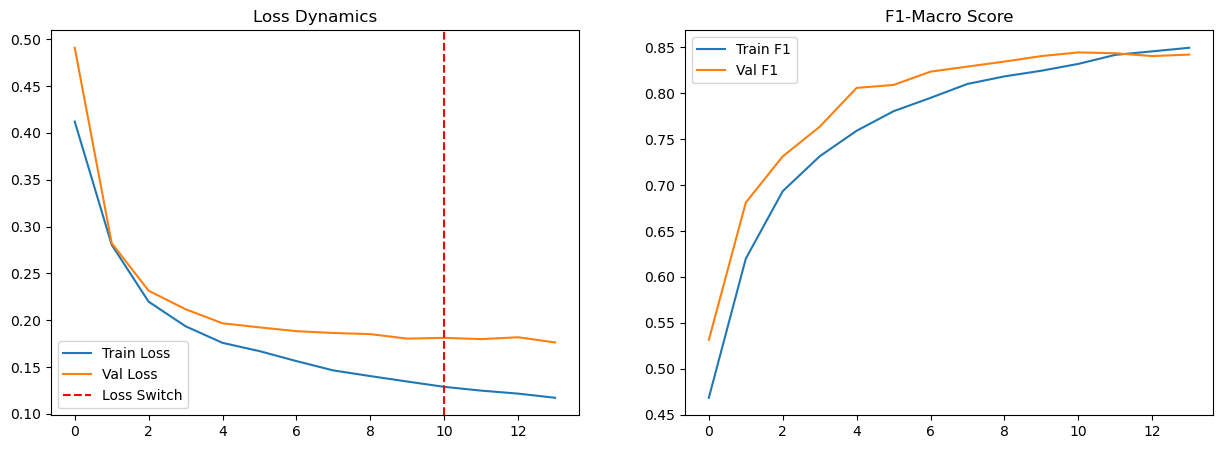

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Best model F1-macro: 0.8443


In [23]:
num_classes = 20

def CNN(vocab_size, embed_dim, input_len, num_classes):
    inp = Input(shape=(input_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inp)

    convs = []
    for size in [3, 4, 5]:
        c = Conv1D(128, kernel_size=size, activation='relu')(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model = CNN(vocab_size, embed_dim=256, input_len=max_len, num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=WeightedBinaryCrossentropy(class_weights),
    metrics=[F1Macro()]
)

callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=3, mode='max', restore_best_weights=True),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    LearningRateScheduler(warmup_exp_decay),
    CSVLogger('training_log.csv'),
    LossSwitcher(switch_epoch=10, new_loss=FocalLoss())
]


sample_weights = np.sum(y_train_full * class_weights, axis=1)
history = model.fit(
    X_train_pad,
    y_train_full,
    sample_weight=sample_weights,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


plot_training_history(history, switch_epoch=10)

best_model = tf.keras.models.load_model('best_model.keras',
                                      custom_objects={
                                          'F1Macro': F1Macro,
                                          'FocalLoss': FocalLoss,
                                          'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy
                                      })

y_pred = best_model.predict(X_val_pad) > 0.5
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")

#### результат такой же, как с 1000 примерами (хуже, чем без генерации), сгенерированные примеры некачественные

### Результат на кагле

In [2]:
#!pip install scikit-multilearn
#!pip install tqdm
#!pip install pymorphy2
#!pip install transformers
#!pip install transliterate

#!pip install torch==1.13.1
#!pip uninstall -y scipy gensim numpy tensorflow nltk
#!pip install numpy==1.26.4 scipy==1.12.0 gensim==4.3.2 tensorflow==2.16.1 nltk==3.8.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import IterativeStratification
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem.snowball import RussianStemmer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.multioutput import MultiOutputClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import torch.optim as optim
import gensim
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras.metrics import Precision, Recall
import transformers
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoModelForSequenceClassification
from transformers import create_optimizer
from torch.optim import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, LSTM, Bidirectional
from tensorflow.keras.models import Model
from transliterate import translit
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import inspect
import collections

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alinacesnokova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


max_len: 114
Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - f1_macro: 0.4698 - loss: 0.4489
Epoch 1: val_f1_macro improved from -inf to 0.53582, saving model to best_model.keras
738/738 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - f1_macro: 0.4699 - loss: 0.4489 - val_f1_macro: 0.5358 - val_loss: 0.4881 - learning_rate: 1.0000e-05
Epoch 2/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - f1_macro: 0.5967 - loss: 0.3281
Epoch 2: val_f1_macro improved from 0.53582 to 0.68501, saving model to best_model.keras
738/738 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - f1_macro: 0.5967 - loss: 0.3281 - val_f1_macro: 0.6850 - val_loss: 0.2659 - learning_rate: 2.0800e-04
Epoch 3/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - f1_macro: 0.6941 - loss: 0.2260
Epoch 3: val_f1_macro improved from 0.68501 to 0.75122, saving model to best_model.keras
738/738 ━━━━━━━━━━━━━━━━━━━━ 52s 71ms/step - f1_macro: 0.6941 - loss: 0.2260 - val_f1_macro: 0.7512 - val_loss: 0.2203 - learning_rate: 4.0600e-04
Epoch 4/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 76

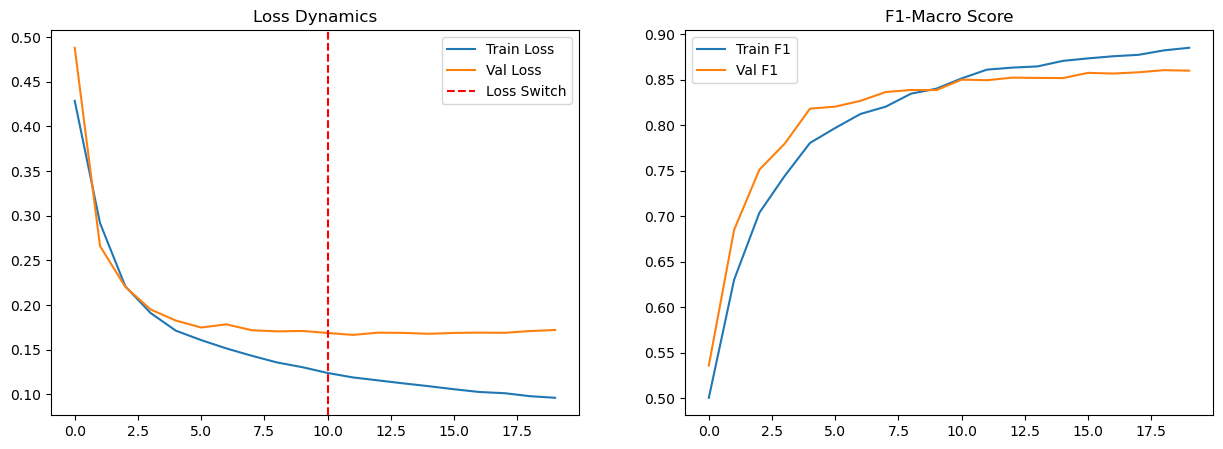

186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Best model F1-macro: 0.8606
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Общий оптимальный порог: 0.504
Macro F1 с общим порогом: 0.861


In [41]:
df = pd.read_csv('train.csv')

#Препроцессинг
import inspect
if not hasattr(inspect, 'getargspec'):
    import collections
    def getargspec(func):
        sig = inspect.signature(func)
        args = []
        varargs = None
        varkw = None
        defaults = []
        for param in sig.parameters.values():
            if param.kind == param.VAR_POSITIONAL:
                varargs = param.name
            elif param.kind == param.VAR_KEYWORD:
                varkw = param.name
            else:
                args.append(param.name)
                if param.default is not param.empty:
                    defaults.append(param.default)
        return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(args, varargs, varkw, tuple(defaults) if defaults else None)
    inspect.getargspec = getargspec

tqdm.pandas()
morph = pymorphy2.MorphAnalyzer()
stemmer = RussianStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

def preprocess_text(text, method='lemmatize'):

    text = re.sub(r'\b[a-z]+_[a-z0-9]+\b', '[SOCIAL]', text)  # Соцметки
    text = re.sub(r'\b[a-z]+[0-9]+\b', '[SOCIAL]', text)       # Хэштеги
    text = re.sub(r'\b[a-z]{1,3}\b', ' ', text)               # Удаляем короткие
    text = re.sub(r'\b[a-z]{4,}\b', '[ENG]', text)           # Остальные → [ENG]

    # Удаление email и URL
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    # Удаление дат (01.01.2023, 01/01/2023)
    text = re.sub(r'\b\d{1,2}[./]\d{1,2}[./]\d{2,4}\b', ' ', text)
    # Удаление времени (12:00, 12-00)
    text = re.sub(r'\b\d{1,2}[:-]\d{2}\b', ' ', text)
    # Удаление ценза (12+)
    text = re.sub(r'\(\d+\+\)', ' ', text)
    # Удаление смайлов и emoji
    text = re.sub(r'[^\w\s,;.!?а-яА-ЯёЁ-]', ' ', text)
    # Замена кавычек разных видов
    text = re.sub(r'[«»"“”„]', ' ', text)
    # Удаление одиночных букв и цифр
    text = re.sub(r'\b[а-яА-Яa-zA-Z]\b', ' ', text)
    text = re.sub(r'\b\d+\b', ' ', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации (кроме дефиса)
    text = re.sub(r'[^\w\s-]', ' ', text)
    tokens = text.split()

    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    # удаление коротких слов и стоп слов
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)


#Деление на трейн и валидацию
y = np.array(df['labels'].apply(lambda x: list(map(int, x.split()))).tolist())
X = df['text'].values

k_fold = IterativeStratification(n_splits=5, order=1)
train_indexes, val_indexes = next(k_fold.split(X, y))

X_train, X_val = X[train_indexes], X[val_indexes]
y_train, y_val = y[train_indexes], y[val_indexes]


#Вспомогательные функции
class_counts = np.sum(y_train, axis=0)
class_weights = len(y_train) / (len(class_counts) * class_counts)

# Нормализация весов
class_weights = class_weights / np.sum(class_weights) * len(class_counts)

class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, name='f1_macro', threshold=0.5, **kwargs):
        super(F1Macro, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        # Инициализируем переменные для каждого класса
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        # Считаем TP, FP, FN для каждого класса
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

        # Обновляем состояния
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1)  # Макро-усреднение

    def reset_state(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))


class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, name='focal_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_pred * y_true + (1 - y_pred) * (1 - y_true)
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = tf.pow(1.0 - p_t, self.gamma)
        return tf.reduce_mean(alpha_factor * modulating_factor * bce, axis=-1)


class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, class_weights=None, name='weighted_binary_crossentropy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.class_weights = class_weights if class_weights is not None else []

    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        if len(self.class_weights) > 0:
            weights = tf.constant(self.class_weights, dtype=tf.float32)
            weighted_bce = bce * tf.reduce_sum(y_true * weights, axis=1)
            return tf.reduce_mean(weighted_bce)
        return tf.reduce_mean(bce)

    def get_config(self):
        config = super().get_config()
        config.update({'class_weights': self.class_weights})
        return config

class LossSwitcher(tf.keras.callbacks.Callback):
    def __init__(self, switch_epoch, new_loss):
        super().__init__()
        self.switch_epoch = switch_epoch
        self.new_loss = new_loss
        self.original_loss = None

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.switch_epoch:
            self.original_loss = self.model.loss
            self.model.loss = self.new_loss
            print(f"\nSwitched loss from {self.original_loss.__class__.__name__} to {self.new_loss.__class__.__name__}")


def warmup_exp_decay(epoch):
    warmup_epochs = 5
    init_lr = 1e-5
    peak_lr = 1e-3
    decay_rate = 0.9

    if epoch < warmup_epochs:
        return init_lr + (peak_lr - init_lr) * (epoch / warmup_epochs)
    else:
        return peak_lr * (decay_rate ** (epoch - warmup_epochs))

def plot_training_history(history, switch_epoch=None):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    if switch_epoch:
        plt.axvline(x=switch_epoch, color='r', linestyle='--', label='Loss Switch')
    plt.title('Loss Dynamics')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_macro'], label='Train F1')
    plt.plot(history.history['val_f1_macro'], label='Val F1')
    plt.title('F1-Macro Score')
    plt.legend()

    plt.show()

#Применение преобразований к данным 
preprocessor = Pipeline([
    ('text_clean', FunctionTransformer(lambda texts: [preprocess_text(t) for t in texts], validate=False))])

X_train_cnn = preprocessor.fit_transform(X_train)
X_val_cnn = preprocessor.transform(X_val)

tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_cnn)

X_train_seq = tokenizer.texts_to_sequences(X_train_cnn)
X_val_seq = tokenizer.texts_to_sequences(X_val_cnn)

lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))
print('max_len:', max_len)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1


#Модель
num_classes = 20

def CNN(vocab_size, embed_dim, input_len, num_classes):
    inp = Input(shape=(input_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_len)(inp)

    convs = []
    for size in [3, 4, 5]:
        c = Conv1D(128, kernel_size=size, activation='relu')(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model = CNN(vocab_size, embed_dim=300, input_len=max_len, num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=WeightedBinaryCrossentropy(class_weights),
    metrics=[F1Macro()]
)

callbacks = [
    EarlyStopping(monitor='val_f1_macro', patience=3, mode='max', restore_best_weights=True),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_f1_macro',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    LearningRateScheduler(warmup_exp_decay),
    CSVLogger('training_log.csv'),
    LossSwitcher(switch_epoch=10, new_loss=FocalLoss())
]


sample_weights = np.sum(y_train * class_weights, axis=1)
history = model.fit(
    X_train_pad,
    y_train,
    sample_weight=sample_weights,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


plot_training_history(history, switch_epoch=10)

best_model = tf.keras.models.load_model('best_model.keras',
                                      custom_objects={
                                          'F1Macro': F1Macro,
                                          'FocalLoss': FocalLoss,
                                          'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy
                                      })

y_pred = best_model.predict(X_val_pad) > 0.5
f1 = f1_score(y_val, y_pred, average='macro')
print(f"Best model F1-macro: {f1:.4f}")


def find_optimal_threshold(model, X_val, y_val, num_classes=20, steps=100):
    #Получаем предсказанные вероятности
    y_probs = model.predict(X_val)
    
    #Диапазон порогов от 0.1 до 0.9 с шагом 0.01
    thresholds = np.linspace(0.1, 0.9, steps)
    best_thresholds = np.zeros(num_classes)
    best_scores = np.zeros(num_classes)
    
    #Поиск для каждого класса отдельно
    for class_idx in range(num_classes):
        max_f1 = 0
        best_thresh = 0.5  #дефолтный порог
        
        for thresh in thresholds:
            #Бинаризация с текущим порогом
            y_pred = (y_probs[:, class_idx] > thresh).astype(int)
            #Вычисляем F1 для текущего класса
            f1 = f1_score(y_val[:, class_idx], y_pred, zero_division=0)
            
            if f1 > max_f1:
                max_f1 = f1
                best_thresh = thresh
        
        best_thresholds[class_idx] = best_thresh
        best_scores[class_idx] = max_f1
    
    #Также найдем общий оптимальный порог для macro F1
    overall_best_thresh = 0.5
    overall_max_f1 = 0
    
    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        f1 = f1_score(y_val, y_pred, average='macro')
        if f1 > overall_max_f1:
            overall_max_f1 = f1
            overall_best_thresh = thresh
    
    return {
        'class_thresholds': best_thresholds,
        'class_scores': best_scores,
        'overall_threshold': overall_best_thresh,
        'overall_score': overall_max_f1
    }
    
threshold_results = find_optimal_threshold(best_model, X_val_pad, y_val)

print(f"\nОбщий оптимальный порог: {threshold_results['overall_threshold']:.3f}")
print(f"Macro F1 с общим порогом: {threshold_results['overall_score']:.3f}")

In [43]:
#Применение модели к тестовым данным
df_test = pd.read_csv('test.csv')
X_test = df_test['text'].values
X_test = preprocessor.transform(X_test)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_test_proba = best_model.predict(test_padded)

#Бинаризуем предсказания
preds_labels = (y_test_proba > 0.504).astype(int)

ss = pd.read_csv('sample_submission.csv')
labels_as_strings = []
for row in preds_labels:
    str_row = [str(label) for label in row]
    labels_as_strings.append(' '.join(str_row))
ss['labels'] = labels_as_strings
ss.to_csv("sample_submissions.csv", index=False)

231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
